# Spatial proteomics
- Author: Jacopo Umberto Verga
- Date: 22/11/2024

## Cropping images

Removing areas with no (or almost no) cells in the selected slides:

In [2]:
import squidpy as sq
import scanpy as sc
import scanpy as sc
from spatialdata import SpatialData
# from spatialdata._core.query.relational_query import _get_unique_label_values_as_index
from spatialdata.datasets import blobs
from spatialdata.models import TableModel, Image2DModel, ShapesModel, Labels2DModel
from spatialdata.transformations import Affine, set_transformation
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata
import spatialdata_plot
import anndata as ad
import os
import sys
import pandas as pd
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import time
import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
adata = sc.read('../data/emd/spe_final.h5ad')
adata.obs['library_id'] = adata.obs['library_id'].astype('str')
adata_bkp = adata.copy()

In [4]:
images_to_crop=['22T25546',]


In [5]:
from anndata import AnnData
from spatialdata import SpatialData

def subset_adata(adata,library_id) -> AnnData:
    adata_tmp = adata[adata.obs['library_id'] == library_id].copy()
    spatial_dict = {}
    spatial_dict[library_id]=adata_tmp.uns['spatial'][library_id]
    adata_tmp.uns['spatial'] = spatial_dict
    return adata_tmp

def create_spatialdata(adata_tmp, library_id) -> SpatialData:
    img=adata_tmp.uns['spatial'][library_id]['images']['hires']
    img=np.transpose(img,(2,0,1))
    images={'img':Image2DModel.parse(img)}
    labels={'mask':Labels2DModel.parse(adata_tmp.uns['spatial'][library_id]['images']['segmentation'])}
    # adata_test.uns[TableModel.ATTRS_KEY]={TableModel.REGION_KEY_KEY: 'library_id'}
    tables={'table':TableModel.parse(adata_tmp,region=[library_id],region_key='library_id',instance_key='ObjectNumber')}
    # full object
    sdata=SpatialData(images=images, labels=labels, tables=tables)
    return sdata


def crop_sdata(sdata, bb_xmin,bb_xmax,bb_ymin,bb_ymax)-> SpatialData:
    cropped_sdata = sdata.query.bounding_box(
        axes=["x", "y"],
        min_coordinate=[bb_xmin, bb_ymin],
        max_coordinate=[bb_xmax, bb_ymax],
        target_coordinate_system="global",
        filter_table=False)
    img = cropped_sdata['img'].values.transpose(1,2,0)
    mask = cropped_sdata['mask'].values
    return cropped_sdata, img, mask


def crop_adata(adata, bb_xmin,bb_xmax,bb_ymin,bb_ymax) -> AnnData:
    data = pd.DataFrame(adata.obsm['spatial'])
    data.index = adata.obs_names
    filtered_data = data[(data[1] >= bb_xmin) & (data[1] <= bb_xmax) & (data[0] >= bb_ymin) & (data[0] <= bb_ymax)]
    adata = adata[filtered_data.index]
    return adata

def update_adata_uns(adata, img, mask, library_id) -> AnnData:
    adata.uns['spatial'][library_id]['images']['hires'] = img
    adata.uns['spatial'][library_id]['images']['segmentation'] = mask
    return adata


def replace_adata(adata, cropped_adata, library_id) -> AnnData:
    # update uns
    adata.uns['spatial'][library_id] = cropped_adata.uns['spatial'][library_id]
    del cropped_adata.uns
    new_uns = adata.uns
    # remove old subset
    adata = adata[-(adata.obs['library_id'] == library_id)]
    # add new subset
    adata = ad.concat([adata,cropped_adata])
    adata.uns = new_uns
    return adata

    
def plot_and_crop(sdata, library_id) -> AnnData:
    while True:
        f, ax = plt.subplots(figsize=(7, 77))
        sdata.pl.render_labels().pl.show(ax=ax)
        plt.show()
        
        input_values = input("Enter x_min, x_max, y_min, y_max separated by spaces: ")
        bb_xmin, bb_xmax, bb_ymin, bb_ymax = map(int, input_values.split())
        bb_w = bb_xmax-bb_xmin
        bb_h = bb_ymax - bb_ymin
        
        f, ax = plt.subplots(figsize=(7, 77))
        sdata.pl.render_labels().pl.show(ax=ax)
        rect = patches.Rectangle((bb_xmin, bb_ymin), bb_w, bb_h, linewidth=3, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        plt.show()
        
        confirmation = input("Is this okay? (yes/no): ").strip().lower()
        
        if confirmation == 'yes':
            cropped_sdata, img, mask=crop_sdata(sdata, bb_xmin,bb_xmax,bb_ymin,bb_ymax)
            adata = cropped_sdata.table
            adata=crop_adata(adata, bb_xmin,bb_xmax,bb_ymin,bb_ymax)
            adata=update_adata_uns(adata, img,mask,library_id)
            break
            
    return adata


def process_adata(adata, library_id):
    adata_tmp = subset_adata(adata,library_id)
    sdata_tmp = create_spatialdata(adata_tmp,library_id)
    adata_tmp = plot_and_crop(sdata_tmp,library_id)
    adata=replace_adata(adata,adata_tmp,library_id)
    return adata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                
INFO     Rasterizing image for faster rendering.                                                                   


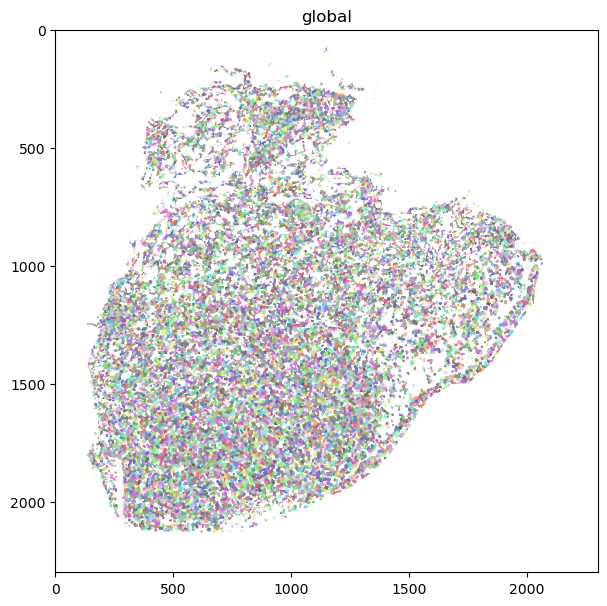

Enter x_min, x_max, y_min, y_max separated by spaces:  0 1400 0 1700


INFO     Rasterizing image for faster rendering.                                                                   


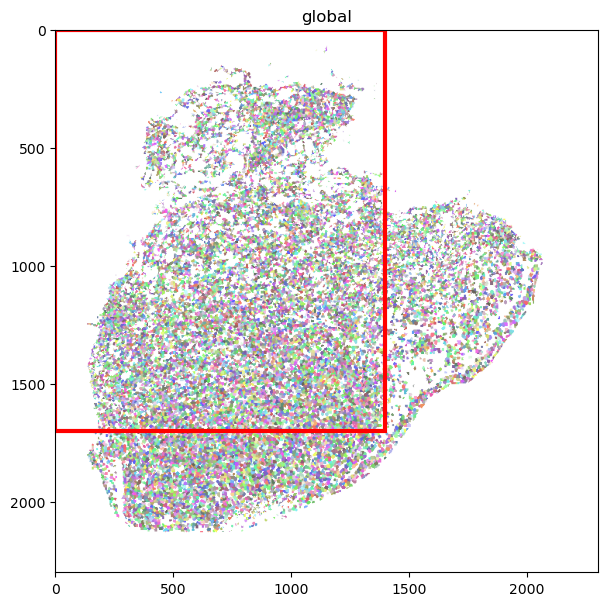

Is this okay? (yes/no):  no


INFO     Rasterizing image for faster rendering.                                                                   


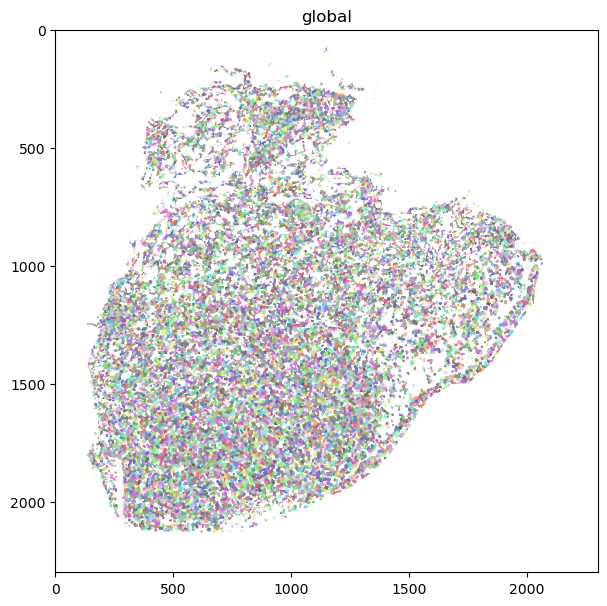

Enter x_min, x_max, y_min, y_max separated by spaces:  0 1300 0 1800


INFO     Rasterizing image for faster rendering.                                                                   


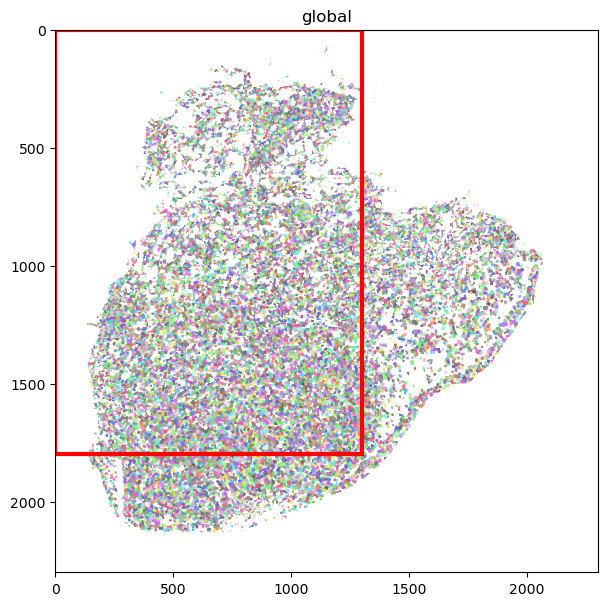

Is this okay? (yes/no):  no


INFO     Rasterizing image for faster rendering.                                                                   


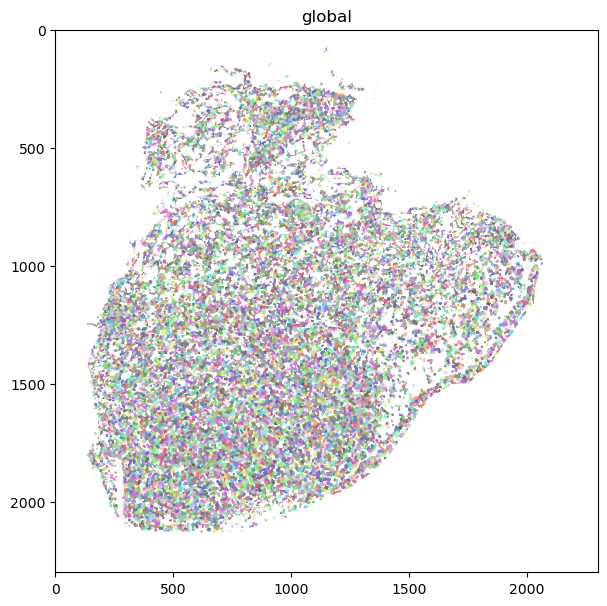

Enter x_min, x_max, y_min, y_max separated by spaces:  0 1350 0 1850


INFO     Rasterizing image for faster rendering.                                                                   


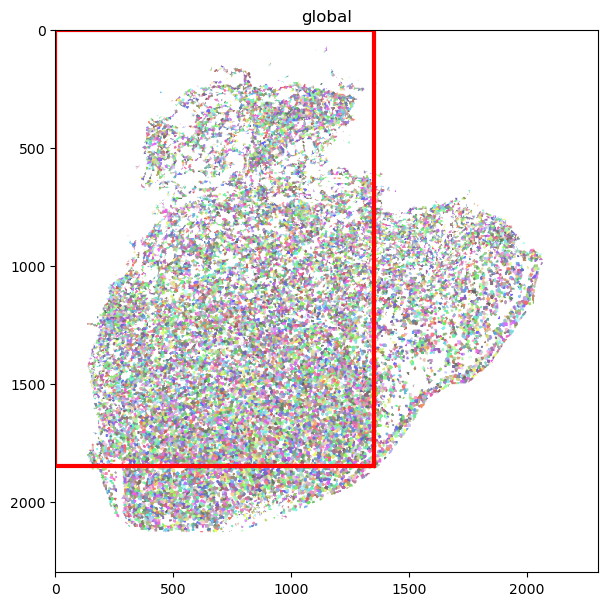

Is this okay? (yes/no):  no


INFO     Rasterizing image for faster rendering.                                                                   


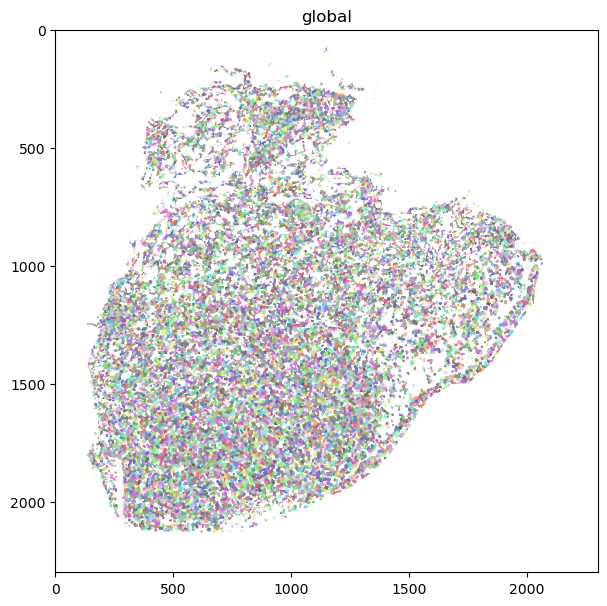

Enter x_min, x_max, y_min, y_max separated by spaces:  0 1325 0 1825


INFO     Rasterizing image for faster rendering.                                                                   


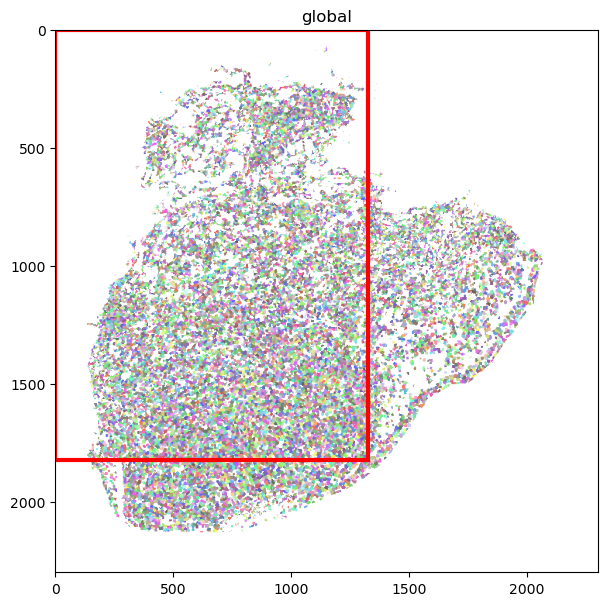

Is this okay? (yes/no):  yes


In [6]:
for library_id in images_to_crop:
    adata=process_adata(adata, library_id)

In [7]:
print(f"Total cells retrieved: {adata.shape[0]}\n\
Original number of cells: {adata_bkp.shape[0]}\n\
Lost cells: {adata_bkp.shape[0]-adata.shape[0]}\n\
Percentage lost cells: {round(((adata_bkp.shape[0]-adata.shape[0])/adata_bkp.shape[0])*100,2)}%")

Total cells retrieved: 103219
Original number of cells: 108636
Lost cells: 5417
Percentage lost cells: 4.99%


In [8]:
adata.write('../data/emd/spe_final_cropped.h5ad')